# T-SNE visualization of hidden states within the Transformer Model

In [64]:
import torch
import sys
sys.path.append("../src")
sys.path.append("../src/models")
from train import getModel, prepare_dataset
from experiments import experiments
import argparse
import tqdm
import numpy as np
from datasets.ConcatDataset import ConcatDataset
import pandas as pd
import geopandas as gpd
import sklearn.metrics
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import sklearn
from TransformerEncoder import TransformerEncoder

figure_path = "/tmp/tsne"#"/home/marc/projects/ISPRS_CropTypeMapping/images/tsne"
os.makedirs(figure_path,exist_ok=True)

def evaluate(model, dataloader):

    probaslist = list()
    targetslist = list()
    idslist = list()
    for iteration, data in tqdm.tqdm(enumerate(dataloader)):
        inputs, targets, ids = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
            model.cuda()
        else:
            model.cpu()

        logprobabilities, deltas, pts, budget = model.forward(inputs.transpose(1, 2))
        probaslist.append(logprobabilities.exp().cpu().detach().numpy())
        targetslist.append(targets.cpu().detach().numpy())
        idslist.append(ids.numpy())

    ids = np.hstack(idslist)
    probas = np.vstack(probaslist)
    targets = np.vstack(targetslist)[:,0]

    return ids, targets, probas


In [50]:
from datasets.BavarianCrops_Dataset import BavarianCropsDataset

def get_dataset(region,partition):
    ds = BavarianCropsDataset(root="../data/BavarianCrops", 
                             region=region, 
                             partition=partition,
                             classmapping = "../data/BavarianCrops/classmapping23.csv", 
                             scheme="blocks",
                             samplet=70, 
                             mode=None)
    
    return ds
    
holltraindataset = get_dataset("holl","train")
holltestdataset =  get_dataset("holl","test")
holltestdataloader = torch.utils.data.DataLoader(dataset=holltestdataset,batch_size=256, num_workers=0)

nowatraindataset = get_dataset("nowa","train")
nowatestdataset =  get_dataset("nowa","test")
nowatestdataloader = torch.utils.data.DataLoader(dataset=nowatestdataset,batch_size=256, num_workers=0)

krumtraindataset = get_dataset("krum","train")
krumtestdataset =  get_dataset("krum","test")
krumtestdataloader = torch.utils.data.DataLoader(dataset=krumtestdataset,batch_size=256, num_workers=0)

Initializing BavarianCropsDataset train partition in holl
read 23 classes
precached dataset files found at ../data/BavarianCrops/npy/classmapping23.csv/blocks/holl/train
loaded 21308 samples
Dataset ../data/BavarianCrops. region holl. partition train. X:21308x(71, 13), y:(21308,) with 23 classes
Initializing BavarianCropsDataset test partition in holl
read 23 classes
precached dataset files found at ../data/BavarianCrops/npy/classmapping23.csv/blocks/holl/test
loaded 9792 samples
Dataset ../data/BavarianCrops. region holl. partition test. X:9792x(144, 13), y:(9792,) with 23 classes
Initializing BavarianCropsDataset train partition in nowa
read 23 classes
precached dataset files found at ../data/BavarianCrops/npy/classmapping23.csv/blocks/nowa/train
loaded 7729 samples
Dataset ../data/BavarianCrops. region nowa. partition train. X:7729x(289, 13), y:(7729,) with 23 classes
Initializing BavarianCropsDataset test partition in nowa
read 23 classes
precached dataset files found at ../data/Ba

In [51]:
dataset = ConcatDataset([holltestdataset, nowatestdataset, krumtestdataset])
alldataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=256, num_workers=0)

nclasses = holltraindataset.nclasses
classname = holltraindataset.classname
klassenname = holltraindataset.klassenname
seqlength = holltraindataset.sequencelength
input_dims = holltraindataset.ndims


In [52]:
hidden_dims = 128
n_heads = 3
n_layers = 3
dropout=0.262039
d_inner = hidden_dims*4
nclasses=34

model = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

model.load("/tmp/data/transformer.pth")

loading model from /tmp/data/transformer.pth


{'optimizer_state_dict': {'state': {140610103741104: {'step': 32120,
    'exp_avg': tensor([-0.0580, -0.3054,  0.0403,  0.0332,  0.0615,  0.1096, -0.0038, -0.0643,
             0.1523, -0.0281,  0.0689, -0.1501,  0.0713]),
    'exp_avg_sq': tensor([0.0751, 0.4166, 0.1345, 0.1067, 0.1635, 0.2287, 0.4350, 0.1573, 0.2611,
            1.6990, 0.2167, 1.6023, 0.0434])},
   140610103741248: {'step': 32120,
    'exp_avg': tensor([ 0.0681,  0.2089, -0.0033, -0.0005, -0.1234, -0.1653,  0.0197,  0.0798,
             0.1725, -0.0065,  0.0559, -0.0791, -0.1310]),
    'exp_avg_sq': tensor([0.3011, 0.1490, 0.1614, 0.4504, 0.4240, 0.4495, 0.5906, 0.7689, 0.4272,
            0.8849, 0.1215, 0.6015, 0.0778])},
   140610116332568: {'step': 32120,
    'exp_avg': tensor([ 2.7595e-03,  6.5208e-03,  1.3199e-04,  4.2977e-03,  5.8357e-03,
            -4.5765e-03,  1.2398e-02, -2.5713e-03,  1.8559e-03, -1.4078e-03,
            -4.3650e-04, -3.0815e-04, -3.4290e-06, -1.8705e-03,  2.3196e-03,
            -5.5870

In [53]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import tqdm

tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumblack=(0,0,0,1)

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm.tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumblue[0],tumblue[1],tumblue[2],arr[o,i,0]*.5)))
                ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax
    

In [54]:
def append_store(feature, fname):
    if not os.path.exists(fname):
        print(f"{fname} does not exist. creating...")
        np.save(fname,feature)
    else:
        db = np.vstack([np.load(fname),feature])
        print(f"adding feature to {fname}. now {db.shape[0]}")
        np.save(fname,db)

def attention_hook(module, inp, out):
    
    enc_output, enc_slf_attn = out
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt("/tmp/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
    np.savetxt("/tmp/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    
    enc_input, enc_input, enc_input = inp
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())

    
def feature_hook(module, inp, out,name="layer_x"):
    enc_out = out[0].cpu().detach().numpy()
    features = enc_out.mean(1)
    store_name=f"/tmp/{name}.npy"
    append_store(features,fname=store_name)
    
def feature_hook0(module, inp, out):
    feature_hook(module, inp, out,"layer_0")
    
def feature_hook1(module, inp, out):
    feature_hook(module, inp, out,"layer_1")
    
def feature_hook2(module, inp, out):
    feature_hook(module, inp, out,"layer_2")
    
def outfeature_hook(module, inp, out):
    name="outlinear"
    enc_inp = inp[0].cpu().detach().numpy()
    features = enc_inp.mean(2)
    store_name=f"/tmp/{name}.npy"
    append_store(features,fname=store_name)
   
model.encoder.layer_stack[0].register_forward_hook(feature_hook0)
model.encoder.layer_stack[1].register_forward_hook(feature_hook1)
model.encoder.layer_stack[2].register_forward_hook(feature_hook2)
model.tempmaxpool.register_forward_hook(outfeature_hook)

def rm(fname):
    if os.path.exists(f"{fname}"):
        print(f"removing {fname}")
        os.remove(f"{fname}")

def rm_all(fld):
    rm(os.path.join(fld,"layer_0.npy"))
    rm(os.path.join(fld,"layer_1.npy"))
    rm(os.path.join(fld,"layer_2.npy"))
    rm(os.path.join(fld,"outlinear.npy"))

In [55]:
rm_all("/tmp")
ids, targets, probas = evaluate(model, holltestdataloader)
features_layer_0 = np.load("/tmp/layer_0.npy")
features_layer_1 = np.load("/tmp/layer_1.npy")
features_layer_2 = np.load("/tmp/layer_2.npy")
outlinear = np.load("/tmp/outlinear.npy")
holl = (ids,targets,probas,features_layer_0,features_layer_1,features_layer_2,outlinear)

rm_all("/tmp")
ids, targets, probas = evaluate(model, nowatestdataloader)
features_layer_0 = np.load("/tmp/layer_0.npy")
features_layer_1 = np.load("/tmp/layer_1.npy")
features_layer_2 = np.load("/tmp/layer_2.npy")
outlinear = np.load("/tmp/outlinear.npy")
nowa = (ids,targets,probas,features_layer_0,features_layer_1,features_layer_2,outlinear)

rm_all("/tmp")
ids, targets, probas = evaluate(model, krumtestdataloader)
features_layer_0 = np.load("/tmp/layer_0.npy")
features_layer_1 = np.load("/tmp/layer_1.npy")
features_layer_2 = np.load("/tmp/layer_2.npy")
outlinear = np.load("/tmp/outlinear.npy")
krum = (ids,targets,probas,features_layer_0,features_layer_1,features_layer_2,outlinear)

0it [00:00, ?it/s]

/tmp/layer_0.npy does not exist. creating...
/tmp/layer_1.npy does not exist. creating...


1it [00:00,  2.23it/s]

/tmp/layer_2.npy does not exist. creating...
/tmp/outlinear.npy does not exist. creating...
adding feature to /tmp/layer_0.npy. now 512
adding feature to /tmp/layer_1.npy. now 512


2it [00:00,  2.16it/s]

adding feature to /tmp/layer_2.npy. now 512
adding feature to /tmp/outlinear.npy. now 512
adding feature to /tmp/layer_0.npy. now 768


3it [00:01,  2.36it/s]

adding feature to /tmp/layer_1.npy. now 768
adding feature to /tmp/layer_2.npy. now 768
adding feature to /tmp/outlinear.npy. now 768
adding feature to /tmp/layer_0.npy. now 1024
adding feature to /tmp/layer_1.npy. now 1024
adding feature to /tmp/layer_2.npy. now 1024


4it [00:01,  2.50it/s]

adding feature to /tmp/outlinear.npy. now 1024
adding feature to /tmp/layer_0.npy. now 1280
adding feature to /tmp/layer_1.npy. now 1280


5it [00:01,  2.71it/s]

adding feature to /tmp/layer_2.npy. now 1280
adding feature to /tmp/outlinear.npy. now 1280
adding feature to /tmp/layer_0.npy. now 1536


6it [00:02,  2.89it/s]

adding feature to /tmp/layer_1.npy. now 1536
adding feature to /tmp/layer_2.npy. now 1536
adding feature to /tmp/outlinear.npy. now 1536
adding feature to /tmp/layer_0.npy. now 1792
adding feature to /tmp/layer_1.npy. now 1792


7it [00:02,  2.75it/s]

adding feature to /tmp/layer_2.npy. now 1792
adding feature to /tmp/outlinear.npy. now 1792
adding feature to /tmp/layer_0.npy. now 2048


8it [00:02,  2.85it/s]

adding feature to /tmp/layer_1.npy. now 2048
adding feature to /tmp/layer_2.npy. now 2048
adding feature to /tmp/outlinear.npy. now 2048


9it [00:03,  3.02it/s]

adding feature to /tmp/layer_0.npy. now 2304
adding feature to /tmp/layer_1.npy. now 2304
adding feature to /tmp/layer_2.npy. now 2304
adding feature to /tmp/outlinear.npy. now 2304


10it [00:03,  3.09it/s]

adding feature to /tmp/layer_0.npy. now 2560
adding feature to /tmp/layer_1.npy. now 2560
adding feature to /tmp/layer_2.npy. now 2560
adding feature to /tmp/outlinear.npy. now 2560
adding feature to /tmp/layer_0.npy. now 2816
adding feature to /tmp/layer_1.npy. now 2816


11it [00:03,  2.89it/s]

adding feature to /tmp/layer_2.npy. now 2816
adding feature to /tmp/outlinear.npy. now 2816
adding feature to /tmp/layer_0.npy. now 3072


12it [00:04,  3.05it/s]

adding feature to /tmp/layer_1.npy. now 3072
adding feature to /tmp/layer_2.npy. now 3072
adding feature to /tmp/outlinear.npy. now 3072


13it [00:04,  3.17it/s]

adding feature to /tmp/layer_0.npy. now 3328
adding feature to /tmp/layer_1.npy. now 3328
adding feature to /tmp/layer_2.npy. now 3328
adding feature to /tmp/outlinear.npy. now 3328


14it [00:04,  3.22it/s]

adding feature to /tmp/layer_0.npy. now 3584
adding feature to /tmp/layer_1.npy. now 3584
adding feature to /tmp/layer_2.npy. now 3584
adding feature to /tmp/outlinear.npy. now 3584


15it [00:05,  3.22it/s]

adding feature to /tmp/layer_0.npy. now 3840
adding feature to /tmp/layer_1.npy. now 3840
adding feature to /tmp/layer_2.npy. now 3840
adding feature to /tmp/outlinear.npy. now 3840


16it [00:05,  3.29it/s]

adding feature to /tmp/layer_0.npy. now 4096
adding feature to /tmp/layer_1.npy. now 4096
adding feature to /tmp/layer_2.npy. now 4096
adding feature to /tmp/outlinear.npy. now 4096
adding feature to /tmp/layer_0.npy. now 4352
adding feature to /tmp/layer_1.npy. now 4352
adding feature to /tmp/layer_2.npy. now 4352


17it [00:05,  3.17it/s]

adding feature to /tmp/outlinear.npy. now 4352
adding feature to /tmp/layer_0.npy. now 4608


18it [00:06,  3.15it/s]

adding feature to /tmp/layer_1.npy. now 4608
adding feature to /tmp/layer_2.npy. now 4608
adding feature to /tmp/outlinear.npy. now 4608
adding feature to /tmp/layer_0.npy. now 4864
adding feature to /tmp/layer_1.npy. now 4864
adding feature to /tmp/layer_2.npy. now 4864
adding feature to /tmp/outlinear.npy. now 4864


20it [00:06,  3.11it/s]

adding feature to /tmp/layer_0.npy. now 5120
adding feature to /tmp/layer_1.npy. now 5120
adding feature to /tmp/layer_2.npy. now 5120
adding feature to /tmp/outlinear.npy. now 5120
adding feature to /tmp/layer_0.npy. now 5376
adding feature to /tmp/layer_1.npy. now 5376
adding feature to /tmp/layer_2.npy. now 5376


21it [00:07,  3.05it/s]

adding feature to /tmp/outlinear.npy. now 5376
adding feature to /tmp/layer_0.npy. now 5632


22it [00:07,  2.95it/s]

adding feature to /tmp/layer_1.npy. now 5632
adding feature to /tmp/layer_2.npy. now 5632
adding feature to /tmp/outlinear.npy. now 5632


23it [00:07,  3.04it/s]

adding feature to /tmp/layer_0.npy. now 5888
adding feature to /tmp/layer_1.npy. now 5888
adding feature to /tmp/layer_2.npy. now 5888
adding feature to /tmp/outlinear.npy. now 5888


24it [00:08,  3.09it/s]

adding feature to /tmp/layer_0.npy. now 6144
adding feature to /tmp/layer_1.npy. now 6144
adding feature to /tmp/layer_2.npy. now 6144
adding feature to /tmp/outlinear.npy. now 6144
adding feature to /tmp/layer_0.npy. now 6400
adding feature to /tmp/layer_1.npy. now 6400
adding feature to /tmp/layer_2.npy. now 6400


25it [00:08,  3.07it/s]

adding feature to /tmp/outlinear.npy. now 6400
adding feature to /tmp/layer_0.npy. now 6656


26it [00:08,  3.03it/s]

adding feature to /tmp/layer_1.npy. now 6656
adding feature to /tmp/layer_2.npy. now 6656
adding feature to /tmp/outlinear.npy. now 6656


27it [00:09,  3.09it/s]

adding feature to /tmp/layer_0.npy. now 6912
adding feature to /tmp/layer_1.npy. now 6912
adding feature to /tmp/layer_2.npy. now 6912
adding feature to /tmp/outlinear.npy. now 6912
adding feature to /tmp/layer_0.npy. now 7168
adding feature to /tmp/layer_1.npy. now 7168
adding feature to /tmp/layer_2.npy. now 7168
adding feature to /tmp/outlinear.npy. now 7168


29it [00:09,  3.15it/s]

adding feature to /tmp/layer_0.npy. now 7424
adding feature to /tmp/layer_1.npy. now 7424
adding feature to /tmp/layer_2.npy. now 7424
adding feature to /tmp/outlinear.npy. now 7424
adding feature to /tmp/layer_0.npy. now 7680
adding feature to /tmp/layer_1.npy. now 7680
adding feature to /tmp/layer_2.npy. now 7680


30it [00:10,  3.02it/s]

adding feature to /tmp/outlinear.npy. now 7680
adding feature to /tmp/layer_0.npy. now 7936


31it [00:10,  3.02it/s]

adding feature to /tmp/layer_1.npy. now 7936
adding feature to /tmp/layer_2.npy. now 7936
adding feature to /tmp/outlinear.npy. now 7936
adding feature to /tmp/layer_0.npy. now 8192
adding feature to /tmp/layer_1.npy. now 8192
adding feature to /tmp/layer_2.npy. now 8192


32it [00:10,  3.06it/s]

adding feature to /tmp/outlinear.npy. now 8192
adding feature to /tmp/layer_0.npy. now 8448


33it [00:10,  3.08it/s]

adding feature to /tmp/layer_1.npy. now 8448
adding feature to /tmp/layer_2.npy. now 8448
adding feature to /tmp/outlinear.npy. now 8448
adding feature to /tmp/layer_0.npy. now 8704
adding feature to /tmp/layer_1.npy. now 8704
adding feature to /tmp/layer_2.npy. now 8704
adding feature to /tmp/outlinear.npy. now 8704


34it [00:11,  3.10it/s]

adding feature to /tmp/layer_0.npy. now 8960
adding feature to /tmp/layer_1.npy. now 8960
adding feature to /tmp/layer_2.npy. now 8960


35it [00:11,  3.04it/s]

adding feature to /tmp/outlinear.npy. now 8960
adding feature to /tmp/layer_0.npy. now 9216


36it [00:11,  3.09it/s]

adding feature to /tmp/layer_1.npy. now 9216
adding feature to /tmp/layer_2.npy. now 9216
adding feature to /tmp/outlinear.npy. now 9216


37it [00:12,  3.17it/s]

adding feature to /tmp/layer_0.npy. now 9472
adding feature to /tmp/layer_1.npy. now 9472
adding feature to /tmp/layer_2.npy. now 9472
adding feature to /tmp/outlinear.npy. now 9472


38it [00:12,  3.21it/s]

adding feature to /tmp/layer_0.npy. now 9728
adding feature to /tmp/layer_1.npy. now 9728
adding feature to /tmp/layer_2.npy. now 9728
adding feature to /tmp/outlinear.npy. now 9728


39it [00:12,  3.08it/s]
0it [00:00, ?it/s]

adding feature to /tmp/layer_0.npy. now 9792
adding feature to /tmp/layer_1.npy. now 9792
adding feature to /tmp/layer_2.npy. now 9792
adding feature to /tmp/outlinear.npy. now 9792
removing /tmp/layer_0.npy
removing /tmp/layer_1.npy
removing /tmp/layer_2.npy
removing /tmp/outlinear.npy
/tmp/layer_0.npy does not exist. creating...


1it [00:00,  3.62it/s]

/tmp/layer_1.npy does not exist. creating...
/tmp/layer_2.npy does not exist. creating...
/tmp/outlinear.npy does not exist. creating...


2it [00:00,  3.58it/s]

adding feature to /tmp/layer_0.npy. now 512
adding feature to /tmp/layer_1.npy. now 512
adding feature to /tmp/layer_2.npy. now 512
adding feature to /tmp/outlinear.npy. now 512


3it [00:00,  3.49it/s]

adding feature to /tmp/layer_0.npy. now 768
adding feature to /tmp/layer_1.npy. now 768
adding feature to /tmp/layer_2.npy. now 768
adding feature to /tmp/outlinear.npy. now 768


4it [00:01,  3.48it/s]

adding feature to /tmp/layer_0.npy. now 1024
adding feature to /tmp/layer_1.npy. now 1024
adding feature to /tmp/layer_2.npy. now 1024
adding feature to /tmp/outlinear.npy. now 1024


5it [00:01,  3.52it/s]

adding feature to /tmp/layer_0.npy. now 1280
adding feature to /tmp/layer_1.npy. now 1280
adding feature to /tmp/layer_2.npy. now 1280
adding feature to /tmp/outlinear.npy. now 1280


6it [00:01,  3.54it/s]

adding feature to /tmp/layer_0.npy. now 1536
adding feature to /tmp/layer_1.npy. now 1536
adding feature to /tmp/layer_2.npy. now 1536
adding feature to /tmp/outlinear.npy. now 1536


7it [00:01,  3.53it/s]

adding feature to /tmp/layer_0.npy. now 1792
adding feature to /tmp/layer_1.npy. now 1792
adding feature to /tmp/layer_2.npy. now 1792
adding feature to /tmp/outlinear.npy. now 1792


8it [00:02,  3.54it/s]

adding feature to /tmp/layer_0.npy. now 2048
adding feature to /tmp/layer_1.npy. now 2048
adding feature to /tmp/layer_2.npy. now 2048
adding feature to /tmp/outlinear.npy. now 2048


9it [00:02,  3.54it/s]

adding feature to /tmp/layer_0.npy. now 2304
adding feature to /tmp/layer_1.npy. now 2304
adding feature to /tmp/layer_2.npy. now 2304
adding feature to /tmp/outlinear.npy. now 2304


10it [00:02,  3.53it/s]

adding feature to /tmp/layer_0.npy. now 2560
adding feature to /tmp/layer_1.npy. now 2560
adding feature to /tmp/layer_2.npy. now 2560
adding feature to /tmp/outlinear.npy. now 2560


11it [00:03,  3.43it/s]

adding feature to /tmp/layer_0.npy. now 2816
adding feature to /tmp/layer_1.npy. now 2816
adding feature to /tmp/layer_2.npy. now 2816
adding feature to /tmp/outlinear.npy. now 2816


12it [00:03,  3.46it/s]

adding feature to /tmp/layer_0.npy. now 3072
adding feature to /tmp/layer_1.npy. now 3072
adding feature to /tmp/layer_2.npy. now 3072
adding feature to /tmp/outlinear.npy. now 3072


13it [00:03,  3.48it/s]

adding feature to /tmp/layer_0.npy. now 3328
adding feature to /tmp/layer_1.npy. now 3328
adding feature to /tmp/layer_2.npy. now 3328
adding feature to /tmp/outlinear.npy. now 3328


14it [00:04,  3.50it/s]
0it [00:00, ?it/s]

adding feature to /tmp/layer_0.npy. now 3572
adding feature to /tmp/layer_1.npy. now 3572
adding feature to /tmp/layer_2.npy. now 3572
adding feature to /tmp/outlinear.npy. now 3572
removing /tmp/layer_0.npy
removing /tmp/layer_1.npy
removing /tmp/layer_2.npy
removing /tmp/outlinear.npy


1it [00:00,  3.70it/s]

/tmp/layer_0.npy does not exist. creating...
/tmp/layer_1.npy does not exist. creating...
/tmp/layer_2.npy does not exist. creating...
/tmp/outlinear.npy does not exist. creating...


2it [00:00,  3.49it/s]

adding feature to /tmp/layer_0.npy. now 512
adding feature to /tmp/layer_1.npy. now 512
adding feature to /tmp/layer_2.npy. now 512
adding feature to /tmp/outlinear.npy. now 512


3it [00:00,  3.51it/s]

adding feature to /tmp/layer_0.npy. now 768
adding feature to /tmp/layer_1.npy. now 768
adding feature to /tmp/layer_2.npy. now 768
adding feature to /tmp/outlinear.npy. now 768


4it [00:01,  3.43it/s]

adding feature to /tmp/layer_0.npy. now 1024
adding feature to /tmp/layer_1.npy. now 1024
adding feature to /tmp/layer_2.npy. now 1024
adding feature to /tmp/outlinear.npy. now 1024


5it [00:01,  3.42it/s]

adding feature to /tmp/layer_0.npy. now 1280
adding feature to /tmp/layer_1.npy. now 1280
adding feature to /tmp/layer_2.npy. now 1280
adding feature to /tmp/outlinear.npy. now 1280


6it [00:01,  3.40it/s]

adding feature to /tmp/layer_0.npy. now 1536
adding feature to /tmp/layer_1.npy. now 1536
adding feature to /tmp/layer_2.npy. now 1536
adding feature to /tmp/outlinear.npy. now 1536


7it [00:02,  3.45it/s]

adding feature to /tmp/layer_0.npy. now 1792
adding feature to /tmp/layer_1.npy. now 1792
adding feature to /tmp/layer_2.npy. now 1792
adding feature to /tmp/outlinear.npy. now 1792


8it [00:02,  3.49it/s]

adding feature to /tmp/layer_0.npy. now 2048
adding feature to /tmp/layer_1.npy. now 2048
adding feature to /tmp/layer_2.npy. now 2048
adding feature to /tmp/outlinear.npy. now 2048


9it [00:02,  3.51it/s]

adding feature to /tmp/layer_0.npy. now 2304
adding feature to /tmp/layer_1.npy. now 2304
adding feature to /tmp/layer_2.npy. now 2304
adding feature to /tmp/outlinear.npy. now 2304


10it [00:02,  3.53it/s]

adding feature to /tmp/layer_0.npy. now 2560
adding feature to /tmp/layer_1.npy. now 2560
adding feature to /tmp/layer_2.npy. now 2560
adding feature to /tmp/outlinear.npy. now 2560


11it [00:03,  3.38it/s]

adding feature to /tmp/layer_0.npy. now 2816
adding feature to /tmp/layer_1.npy. now 2816
adding feature to /tmp/layer_2.npy. now 2816
adding feature to /tmp/outlinear.npy. now 2816


12it [00:03,  3.31it/s]

adding feature to /tmp/layer_0.npy. now 3072
adding feature to /tmp/layer_1.npy. now 3072
adding feature to /tmp/layer_2.npy. now 3072
adding feature to /tmp/outlinear.npy. now 3072


13it [00:03,  3.39it/s]

adding feature to /tmp/layer_0.npy. now 3328
adding feature to /tmp/layer_1.npy. now 3328
adding feature to /tmp/layer_2.npy. now 3328
adding feature to /tmp/outlinear.npy. now 3328


14it [00:04,  3.41it/s]

adding feature to /tmp/layer_0.npy. now 3584
adding feature to /tmp/layer_1.npy. now 3584
adding feature to /tmp/layer_2.npy. now 3584
adding feature to /tmp/outlinear.npy. now 3584


15it [00:04,  3.38it/s]

adding feature to /tmp/layer_0.npy. now 3840
adding feature to /tmp/layer_1.npy. now 3840
adding feature to /tmp/layer_2.npy. now 3840
adding feature to /tmp/outlinear.npy. now 3840


16it [00:04,  3.41it/s]

adding feature to /tmp/layer_0.npy. now 4096
adding feature to /tmp/layer_1.npy. now 4096
adding feature to /tmp/layer_2.npy. now 4096
adding feature to /tmp/outlinear.npy. now 4096


17it [00:04,  3.45it/s]

adding feature to /tmp/layer_0.npy. now 4306
adding feature to /tmp/layer_1.npy. now 4306
adding feature to /tmp/layer_2.npy. now 4306
adding feature to /tmp/outlinear.npy. now 4306


In [56]:
_,holltargets,_,hollfeatures0,hollfeatures1,hollfeatures2, outlinearholl = holl
_,nowatargets,_,nowafeatures0,nowafeatures1,nowafeatures2, outlinearnowa = nowa
_,krumtargets,_,krumfeatures0,krumfeatures1,krumfeatures2, outlinearkrum = krum

# assign each feature an Id for the respective region
hollid = np.ones(hollfeatures2.shape[0],dtype=int)*0
nowaid = np.ones(nowafeatures2.shape[0],dtype=int)*1
krumid = np.ones(krumfeatures2.shape[0],dtype=int)*2

targets = np.hstack([holltargets,nowatargets,krumtargets])
regions = np.hstack([hollid,nowaid,krumid])

In [57]:
def get_uniform_idxs(targets,N_uniform = 50):

    classes = np.unique(targets)
    class_idxs = list()
    idxs = np.array([])
    for c in classes:
        idxs_ = np.argwhere(targets==c)[:N_uniform,0]
        idxs = np.hstack([idxs,idxs_])
    return idxs.astype(int)


def save_plot(fig,fname):
    from matplotlib.backends.backend_pdf import PdfPages
    print(f"writing {fname}")
    with PdfPages(fname) as pdf:
        pdf.savefig(fig,bbox_inches='tight')
    
def save_plot_(fig,fname):
    print(f"writing {fname}")
    fig.savefig(fname,bbox_inches='tight',transparent=True, density=300)

In [58]:
idxs = get_uniform_idxs(targets)

# Fit TSNE on all regions

In [59]:
tumblue  = [0,101,189]
tumblack = [0, 0, 0]
tumbluedark = [0,82,147] 
tumbluelight = [152,198,234] 
tumbluemedium = [100,160,200] 
tumivory = [218,215,203]
tumgreen = [162,173,0]
tumorange = [227,114,34] 
tumaubergine = [105,8,90]
tumturquoise = [0,119,138]
tumgreen = [0,124,48]
tumlimegreen = [103,154,29]
tumyellow = [255,220,0]
tumsand = [249,186,0]
tumredorange = [214,76,19]
tumred = [196,72,27]
tumdarkred = [156,13,22]

cb1 = [252,141,89]
cb2 = [84,39,136]
cb3 = [145,207,96]
cb4 = [153,153,153]
cb5 = [239,138,98]
cb6 = [90,180,172]
customcolor = [0,64,64]

colors = [tumblue, tumblack, tumbluedark, tumbluelight, tumbluemedium, tumivory, tumgreen, tumorange, tumaubergine, tumturquoise, customcolor, tumlimegreen, tumyellow, tumsand, tumredorange, tumred, tumdarkred]
colors = colors + [cb1,cb2,cb3,cb4,cb5,cb6]
colors = np.array(colors)
colors = np.array([np.hstack([c,255]) for c in colors])/255

markers = np.array(["o","v","^","<",">","p","*","D"] * 5)

In [60]:
styles = [
    ['fallow',                tumblack,    '*'],
    ['fallow+flower',         tumblack,    '>'],
    ['alfalfa',               tumgreen,    '*'],
    ['grassland',             tumgreen,    '>'],
    ['proteinplants',         tumbluelight,'*'],
    ['winter wheat',          tumbluedark, '*'],
    ['corn',                  tumred,      '*'],
    ['summer wheat',          tumorange,   '*'],
    ['beetroot',              tumbluelight,'>'],
    ['potatoe',               tumbluelight,'^'],
    ['grassland+machining',   tumgreen,    '^'],
    ['grassland+cattle',      tumgreen,    'D'],
    ['winter spelt',          tumbluedark, '>'],
    ['winter rye',            tumbluedark, '^'],
    ['winter barley',         tumbluedark, 'D'],
    ['summer barley',         tumorange,   '>'],
    ['summer oat',            tumorange,   '^'], 
    ['winter triticale',      tumbluedark, 'o'],
    ['peas',                  tumbluelight,'D'],
    ['beans',                 tumbluelight,'o'],
    ['rapeseed',              tumsand,     '*'],
    ['summer oats (gps)',     tumorange,   'D'],
    ['winter triticale (gps)',tumbluedark, 'D']
]
styles = pd.DataFrame(styles).values
classname = styles[:,0]
colors = styles[:,1]
colors = np.array([np.hstack([c,255]) for c in colors])/255
markers = styles[:,2]

In [65]:
def layer_tsne(features, targets, regions):

    idxs = get_uniform_idxs(targets,N_uniform = 200)

    import sklearn.manifold
    tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300)

    emb = tsne.fit_transform(features[idxs])

    fig,ax = plt.subplots(figsize=(8,8))
    classnames = holltestdataloader.dataset.classname
    for c in np.unique(targets):
        mask = targets[idxs] == c
        x = emb[mask,0]
        y = emb[mask,1]
        sc = ax.scatter(x=x, y=y,c=[colors[c]], marker=markers[c], alpha=.5)

    gcs = sc.legend_elements(num=23)[0]
    #*sc.legend_elements(num=23)

    legend_elements = [Line2D([0], [0], marker=marker, color=color, linewidth=0 , label=name, markersize=8) for color, name, marker in zip(colors,classnames, markers)]

    #legend1 = ax.legend(legend_elements,classnames, title="Class")
    #ax.add_artist(legend1)
    ax.set_ylabel("T-SNE 1")
    ax.set_xlabel("T-SNE 2")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    return fig, emb

def layer_tsne_3d(features, targets, regions):
    from mpl_toolkits.mplot3d import Axes3D 

    idxs = get_uniform_idxs(targets,N_uniform = 200)

    import sklearn.manifold
    tsne = sklearn.manifold.TSNE(n_components=3, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300)

    emb = tsne.fit_transform(features[idxs])

    from mpl_toolkits.mplot3d import Axes3D 

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    classnames = holltestdataloader.dataset.classname
    for c in np.unique(targets):
        mask = targets[idxs] == c
        x = emb[mask,0]
        y = emb[mask,1]
        z = emb[mask,2]
        sc = ax.scatter(xs=x, ys=y, zs=z,c=[colors[c]], marker=markers[c])

    #gcs = sc.legend_elements(num=23)[0]
    #*sc.legend_elements(num=23)

    #legend_elements = [Line2D([0], [0], marker=marker, color=color, linewidth=0 , label=name, markersize=8) for color, name, marker in zip(colors,classnames, markers)]

    #legend1 = ax.legend(legend_elements,classnames, title="Class")
    #ax.add_artist(legend1)
    ax.set_ylabel("T-SNE 1")
    ax.set_xlabel("T-SNE 2")
    ax.set_xlabel("T-SNE 3")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_zticks([])
    ax.set_zticklabels([])

    return fig

## TSNE of layer 0

/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/transformer_layer0.pdf


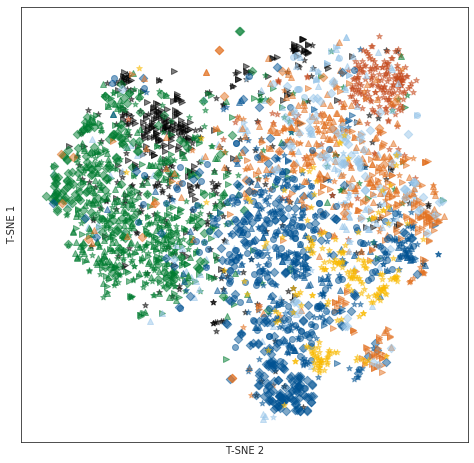

In [66]:
features = np.vstack([hollfeatures0,nowafeatures0,krumfeatures0])
fig,_ = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"transformer_layer0.pdf"))

## TSNE of layer 1

/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/transformer_layer1.pdf


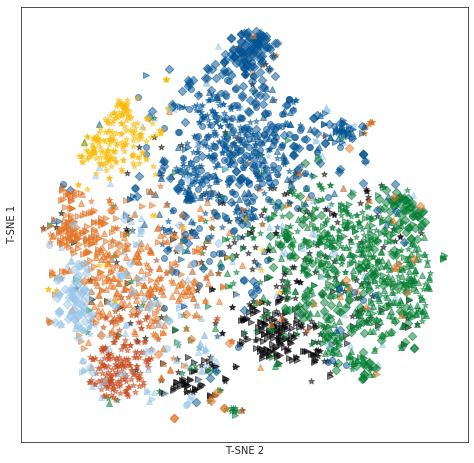

In [67]:
features = np.vstack([hollfeatures1,nowafeatures1,krumfeatures1])
fig,_ = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"transformer_layer1.pdf"))

## TSNE of Layer 2

/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/transformer_layer2.pdf


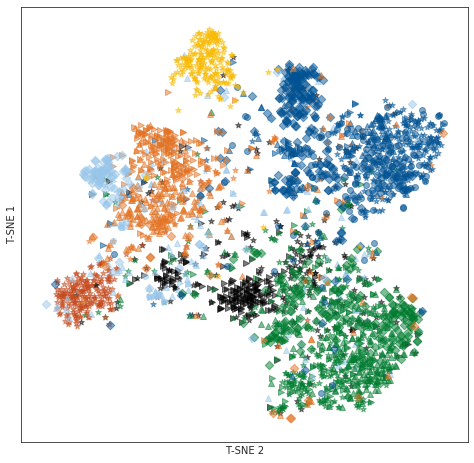

In [68]:
features = np.vstack([hollfeatures2,nowafeatures2,krumfeatures2])
fig,emb = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"transformer_layer2.pdf"))

## TSNE of outlinear

/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/outlinear.pdf


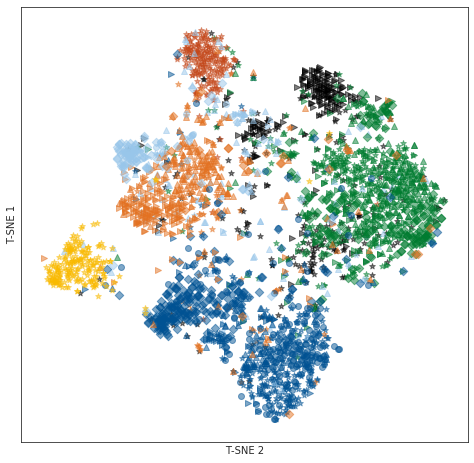

In [69]:
features = np.vstack([outlinearholl,outlinearnowa,outlinearkrum])
fig,emb = layer_tsne(features, targets, regions)
save_plot(fig,os.path.join(figure_path,"outlinear.pdf"))

In [71]:
def region_tsne(selected_class, ax, features, regions, targets):
    
    tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30.0, 
                                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, 
                                 n_iter_without_progress=300)


    mask = targets==selected_class
    selected_features = features[mask]
    selected_regions = regions[mask]
    selected_targets = targets[mask]
    
    idxs = np.arange(selected_regions.shape[0])
    np.random.shuffle(idxs)
    idxs = idxs[:500]
    
    selected_features = selected_features[idxs]
    selected_regions = selected_regions[idxs]
    selected_targets = selected_targets[idxs]
    
    tumorange=np.array([227,114,34,255])/255
    tumblue=np.array([0,101,189,255])/255
    tumbluelight=np.array([152,198,234,255])/255
    tumred=np.array([196,72,27,255])/255

    colors_ = [tumblue,tumorange,tumred]
    regions_ = ["Hollfeld", "Bavarian Forest", "Krumbach"]
    markers_ = markers[:3]
    emb = tsne.fit_transform(selected_features)

    classnames = holltestdataloader.dataset.classname
    for r in np.unique(regions):
        mask = selected_regions == r
        x = emb[mask,0]
        y = emb[mask,1]
        sc = ax.scatter(x=x, y=y,c=[colors_[r]], marker='o', s=40)

    gcs = sc.legend_elements(num=23)[0]
    #*sc.legend_elements(num=23)

    #legend_elements = [Line2D([0], [0], marker='o', color=color, linewidth=0 , label=name, markersize=8) for color, name in zip(colors_, regions_)]

    #legend1 = ax.legend(legend_elements,regions_, title="Class")
    #ax.add_artist(legend1)
    ax.set_ylabel("T-SNE 1")
    ax.set_xlabel("T-SNE 2")
    ax.set_title(classnames[selected_class])
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    return ax


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/fallow.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/fallow+flower.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/alfalfa.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/grassland.png
writing /tmp/tsne/proteinplants.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/winter_wheat.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/corn.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/summer_wheat.png
writing /tmp/tsne/beetroot.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/potatoe.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/grassland+machining.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/grassland+cattle.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/winter_spelt.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/winter_rye.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/winter_barley.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/summer_barley.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/summer_oat.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/winter_triticale.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


writing /tmp/tsne/peas.png
writing /tmp/tsne/beans.png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/rapeseed.png
writing /tmp/tsne/summer_oat_(gps).png


/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/marc/miniconda3/envs/croptypemapping/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


writing /tmp/tsne/winter_triticale_(gps).png


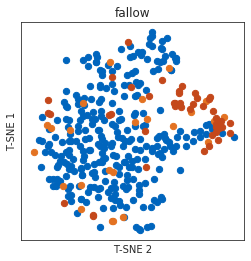

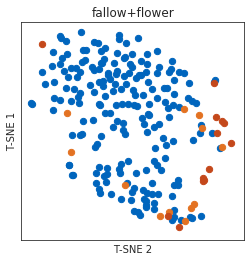

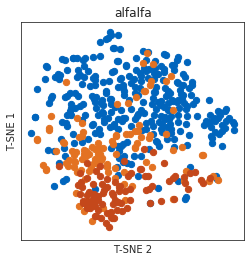

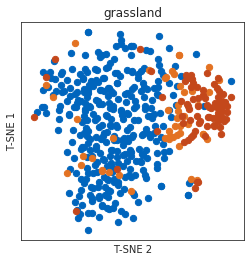

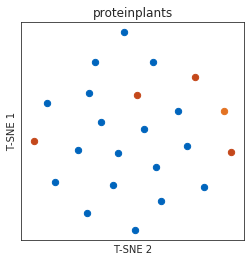

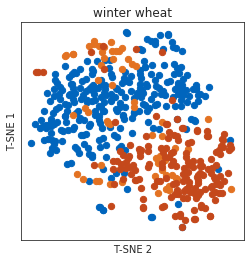

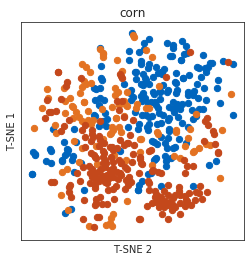

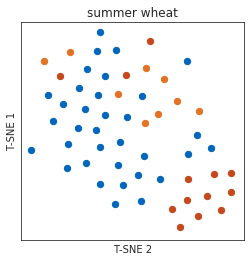

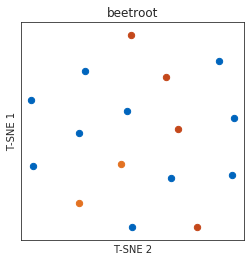

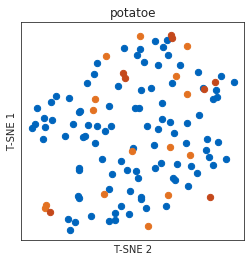

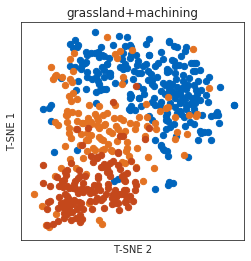

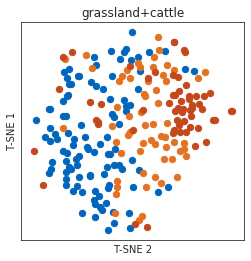

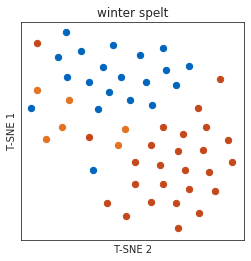

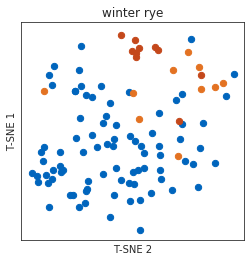

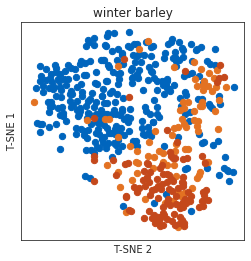

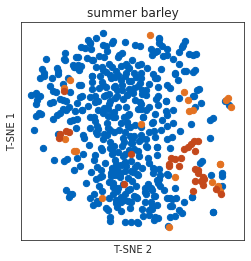

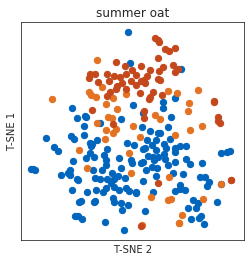

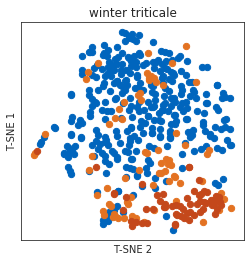

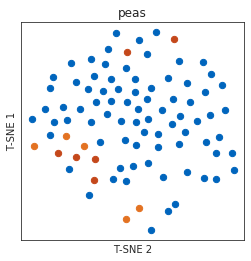

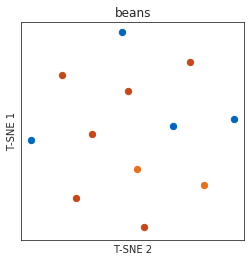

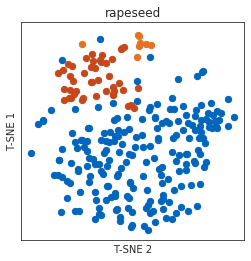

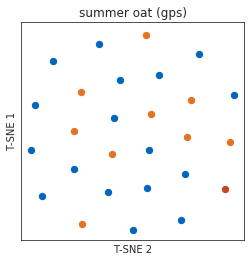

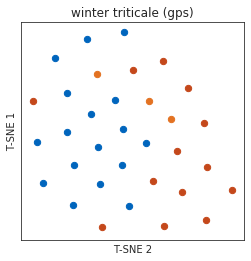

In [72]:
features = np.vstack([hollfeatures2,nowafeatures2,krumfeatures2])
classnames = holltestdataloader.dataset.classname
for i in range(len(classnames)):
    fig,ax = plt.subplots(1, figsize=(4,4))
    ax = region_tsne(i, ax, features, regions, targets)
    name=classnames[i].replace(" ","_")
    save_plot(fig,os.path.join(figure_path,f"{name}.png"))

<IPython.core.display.Javascript object>


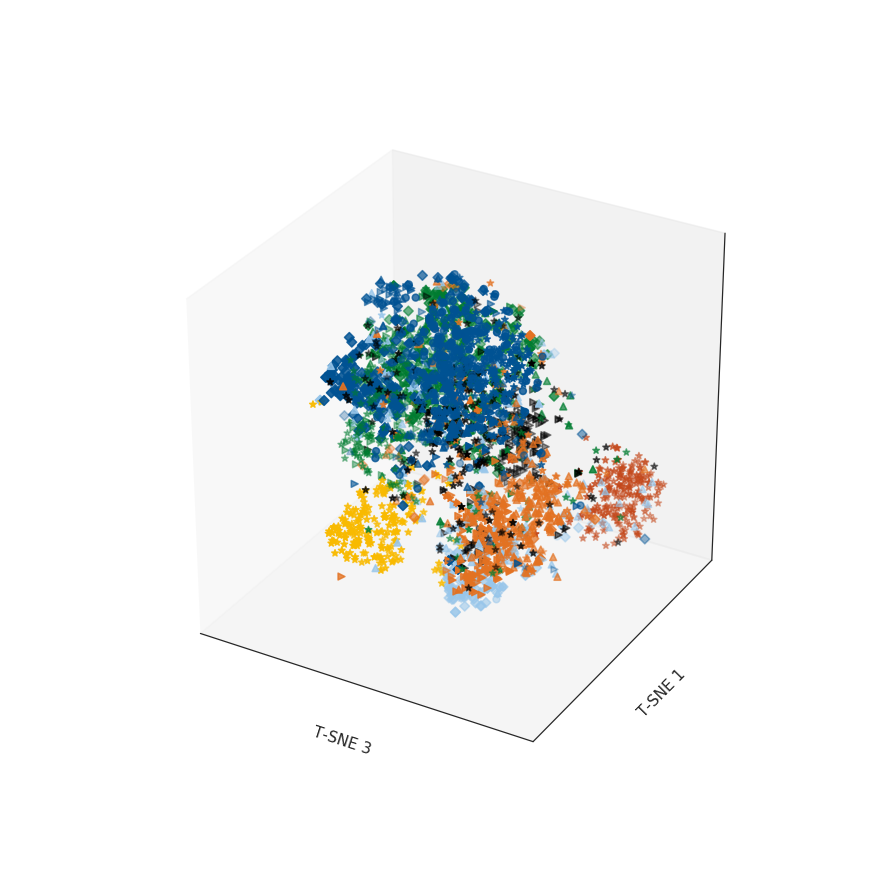

<IPython.core.display.Javascript object>


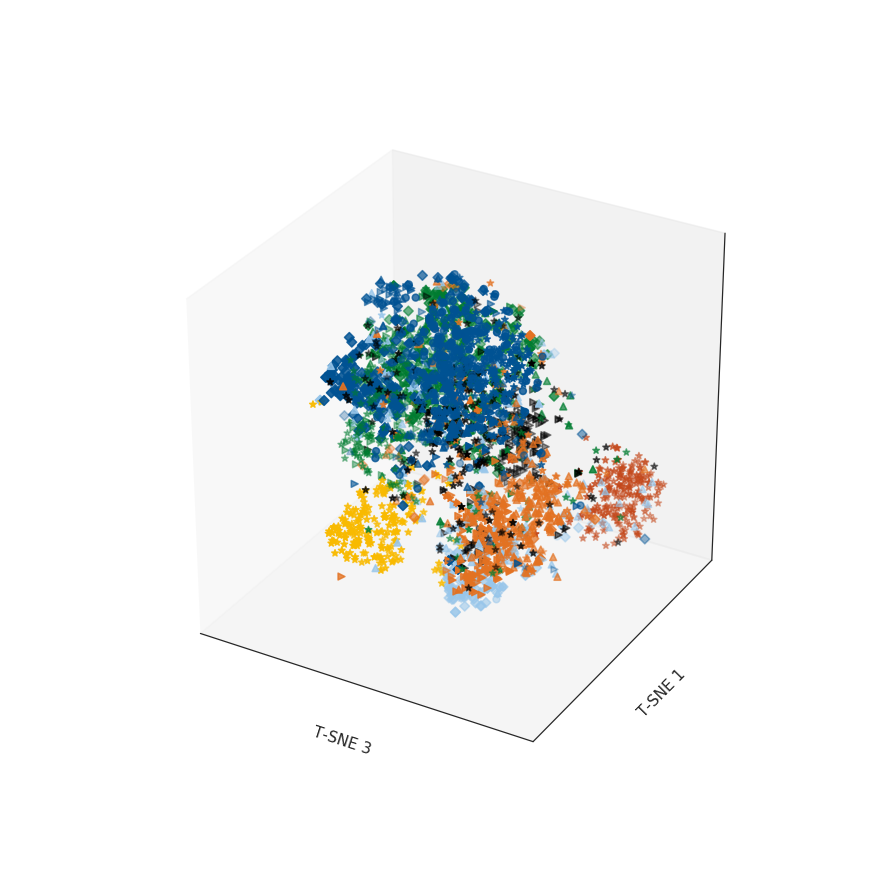

In [73]:
%matplotlib notebook
layer_tsne_3d(features, targets, regions)